# BilbaoCaptions & BilbaoQA datasets generation

### Libraries

In [1]:
import os
import ast
import datasets
import random
import re

from datasets import load_dataset
from PIL import Image
from deep_translator import GoogleTranslator
from langdetect import detect

from mcq import MCQ

c:\Users\User\anaconda3\envs\mucsi-modal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## BilbaoCaptions

### RAW Dataset Loading

In [2]:
dataset = load_dataset('csv', data_files=os.path.join('../data/captions/raw/deia_Bilbao.csv'))
print(len(dataset))
print(dataset["train"] [0])

Found cached dataset csv (C:/Users/User/.cache/huggingface/datasets/csv/default-f738cb8565a51654/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
100%|██████████| 1/1 [00:00<00:00, 71.46it/s]

1
{'img_url': 'https://estaticosgn-cdn.deia.eus/clip/8e292745-252b-4937-9317-7ea706f350b3_16-9-aspect-ratio_default_0.jpg', 'local_path': 'data/imgs/deia/1684340856.612276-28944.jpg', 'caption': 'Papeletas para votar.'}


In [3]:
def load_image(data):
    
    with open(os.path.join('../'+ data["local_path"]), 'rb') as f:
        img = Image.open(f)

        data["image"]=img.convert('RGB')
        return data

In [4]:
train_dataset = dataset["train"]
train_dataset = train_dataset.map(load_image)

Loading cached processed dataset at C:\Users\User\.cache\huggingface\datasets\csv\default-f738cb8565a51654\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-41696eabdfd694a6.arrow


Dataset({
    features: ['img_url', 'local_path', 'caption', 'image'],
    num_rows: 4727
})


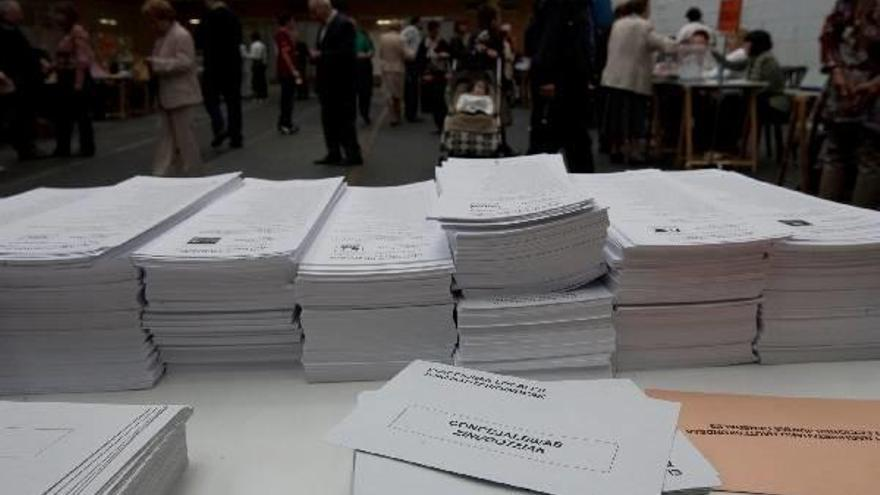

In [5]:
print(train_dataset)
train_dataset['image'][0]

In [6]:
print(train_dataset['caption'][0])

Papeletas para votar.


### Cleaning

In [7]:
print(train_dataset['caption'][5:25])

['De izda. a dcha., Juan Ibarretxe, Asier Alustiza,  Itxaso Olabarri, Susana Palomino y Mikel Sánchez en la inauguración de la exposición.', 'Visitantes en la entrada del Guggenheim.', 'Hospital de Basurto, en una imagen de archivo.', 'La campaña de la Renta en Bizkaia', 'Candidata a diputada general De Madariaga (E. Podemos)', 'Los bomberos sofocan el incendio en una vivienda de Txurdinaga', 'Sector Primario no quieren quedarse al margen en cuanto a equipamientos de Tecnologías de la Información y Comunicaciones', 'Plantación de cereal.', 'La tierra sufre el cambio de la climatología, con temperaturas más altas y menos lluvias.', 'Bilbao Kirolak', 'Parte del equipo de e-sports con el que cuenta la asociación Haszten.', 'Coches de patrulla de la Ertzaintza.', "Tamara Falcó, en 'El Hormiguero'.", 'La tecnificación de los procesos está resultando clave para avanzar en competitividad.', 'Las ferias agrícolas dan la oportunidad de acceder a un producto de calidad y de KM0.', 'La industria 

In [8]:
def clean_captions(example):
    splits = example['caption'].split("|")
    if len(splits) > 1:
        example['caption'] = splits[0].strip()
    example['caption'] = re.sub(r'\s+', ' ', example['caption'])
    print(example['caption'])
    return example

In [10]:
train_dataset = train_dataset.map(clean_captions)

Loading cached processed dataset at C:\Users\User\.cache\huggingface\datasets\csv\default-f738cb8565a51654\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-5ccf13a8998c2e5d.arrow


### Translation

In [8]:
translator=GoogleTranslator(source='auto', target='en')

def translate_caption(example):
    if detect(example["caption"]) !='en':
        example["caption"]=translator.translate(example["caption"])
    return example

In [12]:
print(translator.translate("Cartel de Zientziaz Blai en Bilbao"))
print(translator.translate("Bilboko Udalak eta Kutxabankek merkataritza hobetzeko plataforma bat sortu dute"))
print(translator.translate("Matellanes, Cesidio Niño, Laura Poderoso (BBVA), junto con el elenco de 'Madama Butterfly'"))
print(translator.translate("Las casetas de las librerías se encuentran en la plaza de La estación de Algorta"))

Cartel de Scienciaz Blai in Bilbao
Bilbao City Council and Kutxabank have created a platform to improve trade
Matellanes, Cesidio Niño, Laura Poderoso (BBVA), along with the cast of 'Madama Butterfly'
The booths of the bookstores are located in the square of the Algorta station


In [13]:
train_dataset = train_dataset.map(translate_caption)

In [14]:
print(train_dataset['caption'][0])

Ballots to vote.


### Upload to HuggingFace

In [15]:
train_dataset=train_dataset.remove_columns(["local_path","img_url"])
dd=train_dataset.train_test_split(test_size=0.2)

In [16]:
dd

DatasetDict({
    train: Dataset({
        features: ['caption', 'image'],
        num_rows: 3781
    })
    test: Dataset({
        features: ['caption', 'image'],
        num_rows: 946
    })
})

In [ ]:
!huggingface-cli login

In [20]:
dd.push_to_hub("landersanmi/BilbaoCaptions2")

Pushing split train to the Hub.
Pushing dataset shards to the dataset hub: 100%|██████████| 7/7 [16:51<00:00, 144.53s/it]
Pushing split test to the Hub.
Pushing dataset shards to the dataset hub: 100%|██████████| 2/2 [04:05<00:00, 123.00s/it]


## BilbaoQA

In [2]:
dataset = load_dataset("landersanmi/BilbaoCaptions2")

Found cached dataset parquet (C:/Users/User/.cache/huggingface/datasets/landersanmi___parquet/landersanmi--BilbaoCaptions2-df4e4303f7ec0d96/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


DatasetDict({
    train: Dataset({
        features: ['caption', 'image'],
        num_rows: 3781
    })
    test: Dataset({
        features: ['caption', 'image'],
        num_rows: 946
    })
})


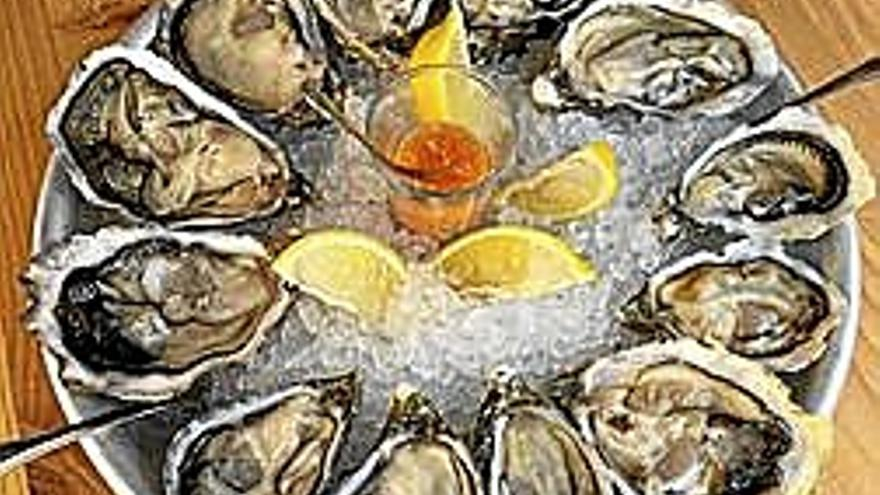

In [3]:
print(dataset)
dataset["train"]["image"][0]

In [4]:
mcq = MCQ()

In [5]:
def reoorganize_data(data):
    
    mcq_output=mcq.generate_MCQ(data["caption"])
    if mcq_output["question"] !="":
        data["question"]= "[QUESTION]"+ mcq_output["question"]
        options=mcq_output["options"]
        options.append(mcq_output["answer"])
        random.shuffle(options)
        data["choices"]=options
        data["answer"]=mcq_output["answer"]
        data["solution"]=""
        data["choices"] = "[OPTIONS]"+" ".join([f"({chr(ord('A') + i)}) {opcion}" for i, opcion in enumerate(data["choices"])])

        data["CTH"] = True if data["solution"] is None or data["solution"] == "" else False
    else:
        data["question"]=""
        data["choices"]=""
        data["answer"]=""
        data["solution"]=""
        data["CTH"]= False

    return data

In [10]:
text="The booths of the bookstores are located in the square of the Algorta station'"
data={"caption":text}
reoorganize_data(data)

{'caption': "The booths of the bookstores are located in the square of the Algorta station'",
 'question': '[QUESTION]Where are the bookstores located?',
 'choices': '[OPTIONS](A) Quest (B) square (C) Bluebird',
 'answer': 'square',
 'solution': '',
 'CTH': True}

In [13]:
list_dest=[dataset["train"],dataset["test"]]
for idx,_ in enumerate(list_dest):
    list_dest[idx] =list_dest[idx].map(reoorganize_data)

In [11]:
list_dest

[Dataset({
     features: ['caption', 'image', 'question', 'choices', 'answer', 'solution', 'CTH'],
     num_rows: 3781
 }),
 Dataset({
     features: ['caption', 'image', 'question', 'choices', 'answer', 'solution', 'CTH'],
     num_rows: 946
 })]

In [12]:
dd = datasets.DatasetDict({"train":list_dest[0],"test":list_dest[1]})

In [ ]:
dd.push_to_hub("landersanmi/BilbaoQA2")